<a href="https://colab.research.google.com/github/ajevnisek/Adversarial-Learning/blob/feature%2Fexercise4/Adversarial_Networks_Solution_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

--- Create and Train a Simple MNIST CNN Classifier ---

In [ ]:
''' Build a simple MNIST classification CNN
    The network takes ~3 minutes to train on a normal laptop and reaches roughly 97% of accuracy
    Model structure: Conv, Conv, Max pooling, Dropout, Dense, Dense
'''
def build_mnist_model():
    
    activation = 'relu'
    # input image dimensions
    img_rows, img_cols, img_colors = 28, 28, 1
    
    model = keras.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='y_pred'))
              
    return model

In [ ]:
''' Normalize input to the range of [0..1]
    Apart from assisting in the convergance of the training process, this 
    will also make our lives easier during the adversarial attack process
'''
def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

In [ ]:
# Load and prepare the datasets for training
num_classes = 10

img_rows, img_cols, img_colors = 28, 28, 1
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
train_images, test_images = normalize(train_images, test_images)
    
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [ ]:
# Train the model
batch_size = 128
maxepoches = 12
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

model = build_mnist_model()




# First conv layer weight - pre-trained

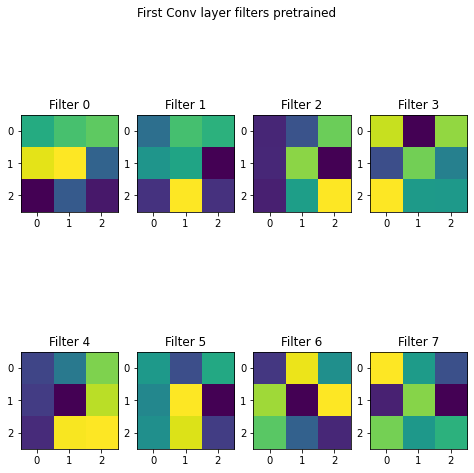

In [ ]:
import matplotlib.pyplot as plt
plt.subplots(2, 4)
for i in range(8):
  plt.subplot(2, 4, i + 1)
  plt.imshow(model.trainable_variables[0][...,i].numpy().reshape(3, 3))
  plt.title(f'Filter {i}')
plt.suptitle('First Conv layer filters pretrained')
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show()
####


## First layer Cosine distance - pre-trained

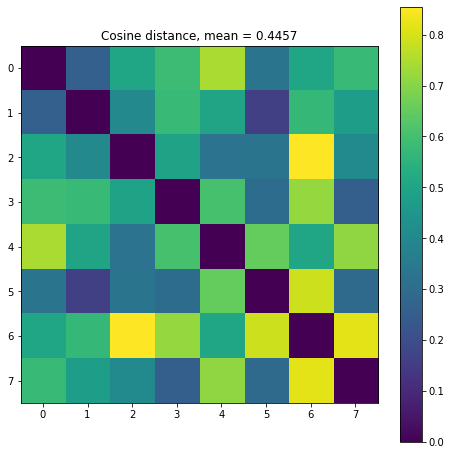

In [ ]:
a = model.trainable_variables[0].numpy()
a = np.moveaxis(a, [0, 1, 2, 3], [2, 3, 0, 1])
a = a.squeeze(0)
a = a.reshape(8, 3 * 3)
a_rows_norm = np.sqrt(np.square(a).sum(axis=1))
a_normed = a / a_rows_norm[:, np.newaxis]
cosine = a_normed @ a_normed.T
cosine_distance = (1 - cosine) * 0.5
## print the cosine distance matrix. Note that it is a symmetric matrix.
plt.imshow(cosine_distance)
plt.colorbar()
plt.title(f'Cosine distance, mean = {cosine_distance.mean():.4f}')
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show()



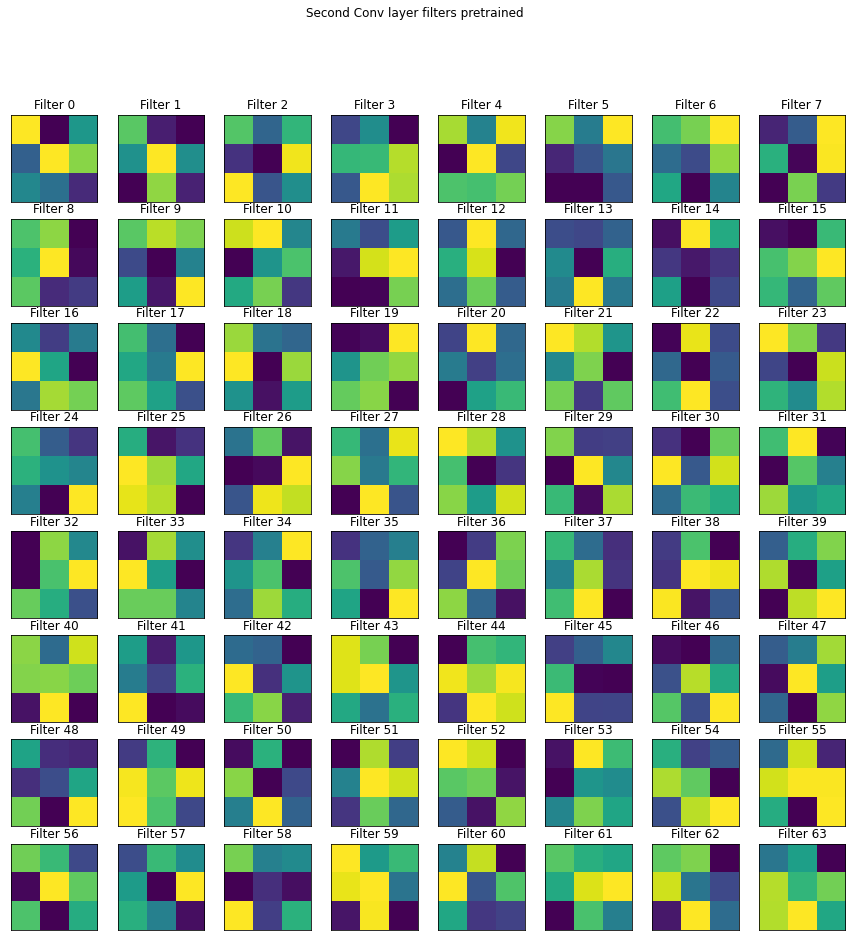

In [ ]:
plt.subplots(8, 8)
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, i*8 + j + 1)
    plt.imshow(model.trainable_variables[2][...,i, j].numpy().reshape(3, 3))
    plt.title(f'Filter {i*8+j}')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('Second Conv layer filters pretrained')
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.show()


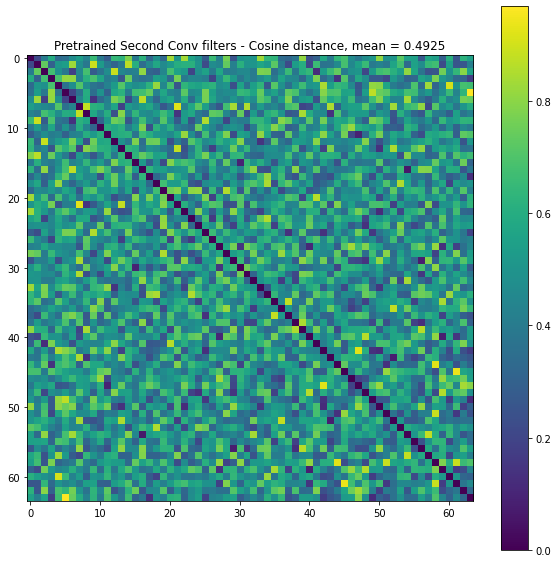

In [ ]:
a = model.trainable_variables[2].numpy()
a = np.moveaxis(a, [0, 1, 2, 3], [2, 3, 0, 1])
# a = a.squeeze(0)
a = a.reshape(8*8, 3 * 3)
a_rows_norm = np.sqrt(np.square(a).sum(axis=1))
a_normed = a / a_rows_norm[:, np.newaxis]
cosine = a_normed @ a_normed.T
cosine_distance = (1 - cosine) * 0.5
## print the cosine distance matrix. Note that it is a symmetric matrix.
plt.imshow(cosine_distance)
plt.colorbar()
plt.title(f'Pretrained Second Conv filters - Cosine distance, mean = {cosine_distance.mean():.4f}')
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=maxepoches,
                    verbose=1,
                    validation_data=(test_images, test_labels),
                    callbacks=[reduce_lr])

Epoch 1/12
469/469 [==============================] - 5s 5ms/step - loss: 1.0422 - categorical_accuracy: 0.6558 - val_loss: 0.3387 - val_categorical_accuracy: 0.9041
Epoch 2/12
469/469 [==============================] - 2s 4ms/step - loss: 0.4973 - categorical_accuracy: 0.8416 - val_loss: 0.2600 - val_categorical_accuracy: 0.9265
Epoch 3/12
469/469 [==============================] - 2s 4ms/step - loss: 0.4182 - categorical_accuracy: 0.8712 - val_loss: 0.2234 - val_categorical_accuracy: 0.9375
Epoch 4/12
469/469 [==============================] - 2s 4ms/step - loss: 0.3641 - categorical_accuracy: 0.8893 - val_loss: 0.1950 - val_categorical_accuracy: 0.9445
Epoch 5/12
469/469 [==============================] - 2s 4ms/step - loss: 0.3295 - categorical_accuracy: 0.9000 - val_loss: 0.1736 - val_categorical_accuracy: 0.9492
Epoch 6/12
469/469 [==============================] - 2s 4ms/step - loss: 0.2996 - categorical_accuracy: 0.9091 - val_loss: 0.1570 - val_categorical_accuracy: 0.9548
Epoc

# Statistics After Training
## First Conv layer weights:

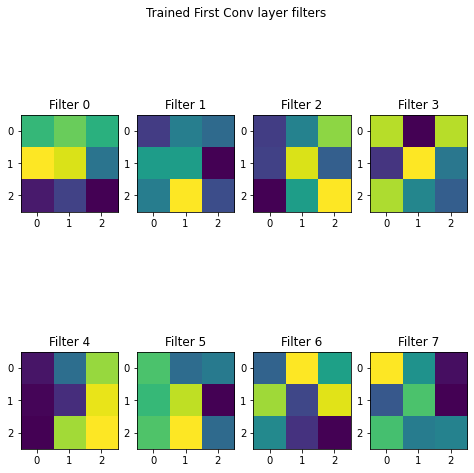

In [ ]:
plt.subplots(2, 4)
for i in range(8):
  plt.subplot(2, 4, i + 1)
  plt.imshow(model.trainable_variables[0][...,i].numpy().reshape(3, 3))
  plt.title(f'Filter {i}')
plt.suptitle('Trained First Conv layer filters')
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show()


## First layer Cosine similarity

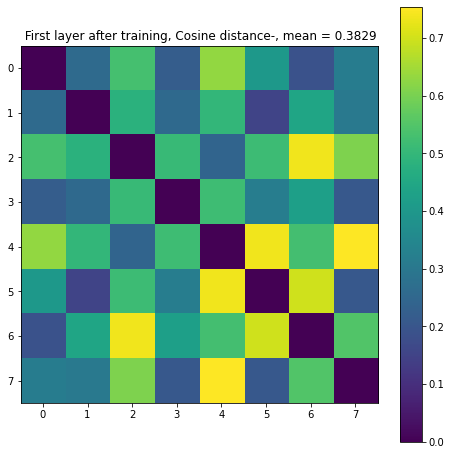

In [ ]:
a = model.trainable_variables[0].numpy()
a = np.moveaxis(a, [0, 1, 2, 3], [2, 3, 0, 1])
a = a.squeeze(0)
a = a.reshape(8, 3 * 3)
a_rows_norm = np.sqrt(np.square(a).sum(axis=1))
a_normed = a / a_rows_norm[:, np.newaxis]
cosine = a_normed @ a_normed.T
cosine_distance = (1 - cosine) * 0.5
## print the cosine distance matrix. Note that it is a symmetric matrix.
plt.imshow(cosine_distance)
plt.colorbar()
plt.title(f' First layer after training, Cosine distance-, mean = {cosine_distance.mean():.4f}')
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show()


## Second layer weights

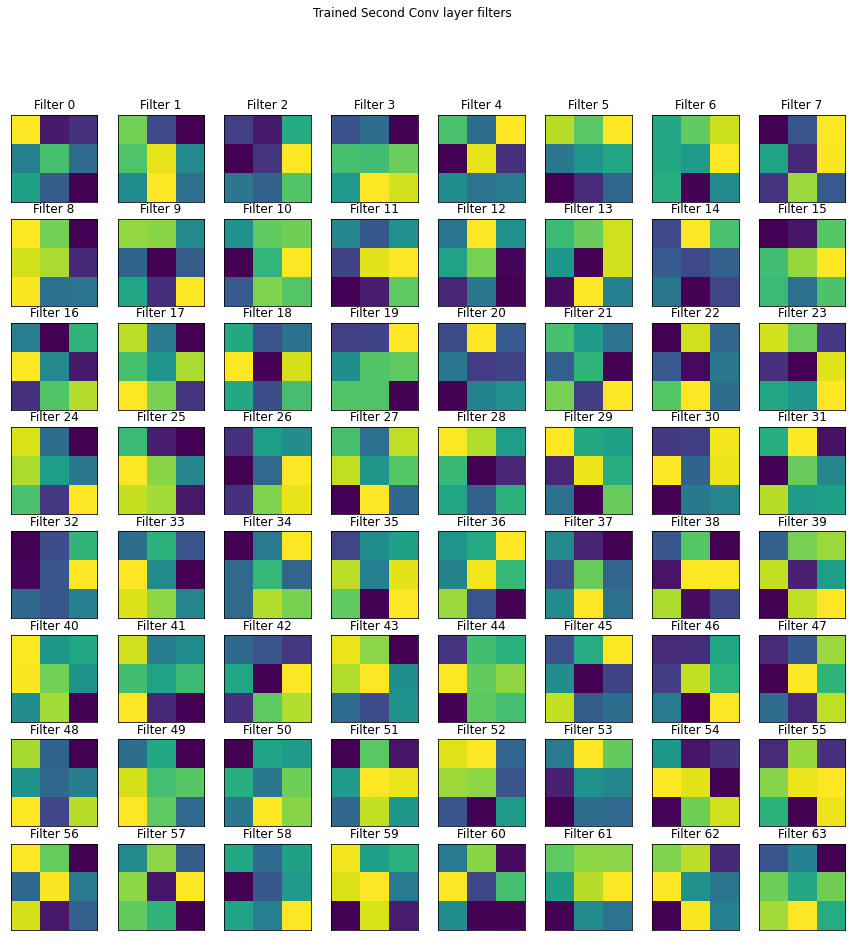

In [ ]:

plt.subplots(8, 8)
for i in range(8):
  for j in range(8):
    plt.subplot(8, 8, i*8 + j + 1)
    plt.imshow(model.trainable_variables[2][...,i, j].numpy().reshape(3, 3))
    plt.title(f'Filter {i*8+j}')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('Trained Second Conv layer filters ')
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.show()

## Second layer cosine similarity

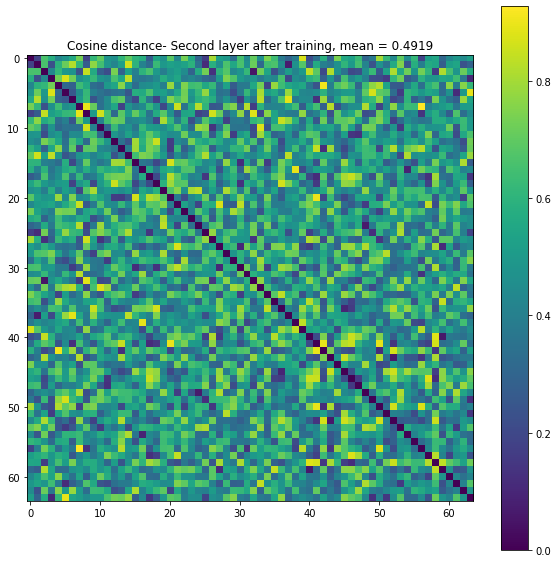

In [ ]:
a = model.trainable_variables[2].numpy()
a = np.moveaxis(a, [0, 1, 2, 3], [2, 3, 0, 1])
# a = a.squeeze(0)
a = a.reshape(8*8, 3 * 3)
a_rows_norm = np.sqrt(np.square(a).sum(axis=1))
a_normed = a / a_rows_norm[:, np.newaxis]
cosine = a_normed @ a_normed.T
cosine_distance = (1 - cosine) * 0.5
## print the cosine distance matrix. Note that it is a symmetric matrix.
plt.imshow(cosine_distance)
plt.colorbar()
plt.title(f'Cosine distance- Second layer after training, mean = {cosine_distance.mean():.4f}')
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()